# my_loss.py のテスト

In [1]:
# モジュールimport
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from model import my_loss, define_model, multi_loss


Using TensorFlow backend.


my_loss.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file


In [2]:
from keras import backend as K

def get_base_model():
    out_dir='output_test/100x100'
    shape=[100, 100, 3]
    num_classes=5
    choice_model='VGG16'# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
    trainable=15
    FCnum=0
    FCpool='GlobalAveragePooling2D'
    activation='sigmoid'# ['sigmoid','softmax']

    model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                            , choice_model, trainable
                                                            , FCnum
                                                            , FCpool=FCpool
                                                            , activation=activation 
                                                          )
    #model.compile(loss=[my_loss.binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=optim)
    #model.summary()
    return model

C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


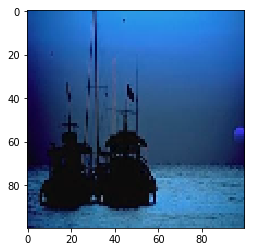

In [3]:
# Downloading and Viewing the dataset

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
#Jupyterでインライン表示するための宣言
%matplotlib inline

num_classes=5
train_batch_size=68#17
valid_batch_size=37#6
epochs=5

def load():
    f = h5py.File("dataset.h5")
    x = f['x'].value
    y = f['y'].value
    f.close()
    
    x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)
    
    # Making the data channel last
    x_train = np.rollaxis(x_train, 1, 4)
    x_test = np.rollaxis(x_test, 1, 4)
    
    # Normalizing data
    x_train = x_train  / 255.0
    x_test = x_test / 255.0
   
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load()

horizontal_flip=True
vertical_flip=True
rotation_range=60
zoom_range=[0.5, 1.9]
shear_range=0.2

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
    rotation_range=rotation_range,  # randomly rotate images in the range (degrees, 0 to 180)
    horizontal_flip=horizontal_flip,  # randomly flip images
    vertical_flip=vertical_flip,  # randomly flip images
    shear_range = shear_range,
    zoom_range=zoom_range
)

plt.imshow(x_train[0])

In [4]:
# モデルコンパイル
model = get_base_model()
model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy)
              , optimizer=define_model.get_optimizers('sgd')
              , metrics=['accuracy', 'binary_accuracy', multi_loss.masked_accuracy])

model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                    , steps_per_epoch=x_train.shape[0] // train_batch_size
                                    , epochs=epochs
                                    , validation_data=(x_test, y_test)
                                    , verbose=1)

----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 15
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True


C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v3\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


----- FC_layer -----
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
Epoch 1/5
23/23 [==============================] - 6s 241ms/step - loss: 0.5726 - acc: 0.2978 - binary_accuracy: 0.7530 - masked_accuracy: 0.7530 - val_loss: 0.5497 - val_acc: 0.3700 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525
Epoch 2/5
23/23 [==============================] - 3s 134ms/step - loss: 0.5249 - acc: 0.3429 - binary_accuracy: 0.7577 - masked_accuracy: 0.7577 - val_loss: 0.4959 - val_acc: 0.4150 - val_binary_accuracy: 0.7605 - val_masked_accuracy: 0.7605
Epoch 3/5
23/23 [==============================] - 3s 130ms/step - loss: 0.4479 - acc: 0.4441 - binary_accuracy: 0.7943 - masked_accuracy: 0.7943 - val_loss: 0.3829 - val_acc: 0.5875 - val_binary_accuracy: 0.8280 - val_masked_accuracy: 0.8280
Epoch 4/5
23/23 [==============================] - 3s 125ms/step - loss: 0.4033 - acc: 0.5147 - binary_accuracy: 0.8119 - masked_accuracy: 0.8119 - val_loss: 

In [8]:
# モデルコンパイル
model = get_base_model()
model.compile(loss=my_loss.binary_focal_loss(alpha=1.0, gamma=0)
              , metrics=["accuracy", 'binary_accuracy', multi_loss.masked_accuracy]
              , optimizer=define_model.get_optimizers('sgd'))

model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                    , steps_per_epoch=x_train.shape[0] // train_batch_size
                                    , epochs=epochs
                                    , validation_data=(x_test, y_test)
                                    , verbose=1)

----- model_param -----
output_dir = output_test/100x100
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 15
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
----- FC_layer -----
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
Epoch 1/5
23/23 [==============================] - 3s 135ms/step - loss: 319.5812 - acc: 0.2288 - binary_accuracy: 0.7526 - masked_accuracy: 0.7526 - val_loss: 333.2642 - val_acc: 0.2100 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525
Epoch 2/5
23/23 [==============================] - 3s 129ms/step - loss: 332.3843 - acc: 0.2021 - binary_accuracy: 0.7528 - masked_accuracy: 0.7528 - val_loss: 333.2744 - val_acc: 0.2100 - val_binary_accuracy: 0.7525 - val_masked_accuracy: 0.7525
Epoch 3/5
23/23 [==============================] - 3s 129ms/step - loss: 329.5899 - acc: 0.2102 - binar

In [17]:
# モデルコンパイル
multi_label_focal_loss = my_loss.multi_label_focal_loss([1, 1, 1, 1, 1], alpha=1, gamma=0)
model.compile(loss=multi_loss.build_masked_loss(multi_label_focal_loss), metrics=["accuracy", 'binary_accuracy', multi_loss.masked_accuracy], optimizer=optim)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=train_batch_size)
                                    , steps_per_epoch=x_train.shape[0] // train_batch_size
                                    , epochs=epochs
                                    , validation_data=(x_test, y_test)
                                    , verbose=1)

Epoch 1/5
23/23 [==============================] - 3s 140ms/step - loss: nan - acc: 0.2039 - binary_accuracy: 0.0000e+00 - masked_accuracy: 0.0000e+00 - val_loss: nan - val_acc: 0.2100 - val_binary_accuracy: 0.0000e+00 - val_masked_accuracy: 0.0000e+00
Epoch 2/5
23/23 [==============================] - 3s 133ms/step - loss: nan - acc: 0.1999 - binary_accuracy: 0.0000e+00 - masked_accuracy: 0.0000e+00 - val_loss: nan - val_acc: 0.2100 - val_binary_accuracy: 0.0000e+00 - val_masked_accuracy: 0.0000e+00
Epoch 3/5
23/23 [==============================] - 3s 129ms/step - loss: nan - acc: 0.2102 - binary_accuracy: 0.0000e+00 - masked_accuracy: 0.0000e+00 - val_loss: nan - val_acc: 0.2100 - val_binary_accuracy: 0.0000e+00 - val_masked_accuracy: 0.0000e+00
Epoch 4/5
23/23 [==============================] - 3s 131ms/step - loss: nan - acc: 0.1977 - binary_accuracy: 0.0000e+00 - masked_accuracy: 0.0000e+00 - val_loss: nan - val_acc: 0.2100 - val_binary_accuracy: 0.0000e+00 - val_masked_accuracy:

In [ ]:
# https://www.kaggle.com/rejpalcz/focalloss-for-keras

# define some results
Y_true = np.array([[0, 1, 0, 1, 0], [1, 0, 1, 0, 1]])
Y_pred = np.array([[0.1, 0.2, 0.3, 0.4, 0.5], [0.6, 0.7, 0.8, 0.9, 1]], dtype=np.float32)

## 不均衡データセットに対する焦点喪失を伴う多クラス分類
- https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/
- https://github.com/Tony607/Focal_Loss_Keras
- 非常に不均衡なデータセットが与えられた場合に焦点損失を適用してマルチクラス分類器モデルを学習させる方法
    - 合計6354407の正常および8213の不正行為事例、すなわち733：1の極端なクラス不均衡データで試す
    - https://www.kaggle.com/ntnu-testimon/paysim1

### class_weightを使って  訓練するベースラインモデルを設定する場合

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
np.random.seed(42)

In [14]:
# create data frame containing your data, each column can be accessed # by df['column   name']
dataset = pd.read_csv(r'D:\work\kaggle_data\fraud_detection_dataset_on_Kaggle\paysim1/PS_20174392719_1491204439457_log.csv')
del dataset['nameDest']
del dataset['nameOrig']
del dataset['type']

dataset.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [15]:
dataset['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [16]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma

In [17]:
#Splitting the Training/Test Data

from sklearn.model_selection  import train_test_split
X, y = dataset.iloc[:,:-2], dataset.iloc[:, -2]
y = keras.utils.to_categorical(y, num_classes=2)
X = feature_normalize(X.as_matrix())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [19]:
from keras.models import Sequential
import tensorflow as tf

model = Sequential()

from keras.layers import Dense

input_dim = X_train.shape[1]
nb_classes = y_train.shape[1]

model.add(Dense(10, input_dim=input_dim, activation='relu', name='input'))
model.add(Dense(20, activation='relu', name='fc1'))
model.add(Dense(10, activation='relu', name='fc2'))
model.add(Dense(nb_classes, activation='softmax', name='output'))

In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 10)                70        
_________________________________________________________________
fc1 (Dense)                  (None, 20)                220       
_________________________________________________________________
fc2 (Dense)                  (None, 10)                210       
_________________________________________________________________
output (Dense)               (None, 2)                 22        
Total params: 522
Trainable params: 522
Non-trainable params: 0
_________________________________________________________________


In [22]:
# from sklearn.utils import class_weight
# class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight = {0 : 1., 1: 20.}
model.fit(X_train, y_train, epochs=3, batch_size=1000, class_weight=class_weight)

Epoch 1/3
5090096/5090096 [==============================] - 21s 4us/step - loss: 0.0570 - acc: 0.9980
Epoch 2/3
5090096/5090096 [==============================] - 21s 4us/step - loss: 0.0403 - acc: 0.9973
Epoch 3/3
5090096/5090096 [==============================] - 21s 4us/step - loss: 0.0382 - acc: 0.9977


In [23]:
score = model.evaluate(X_test, y_test, batch_size=1000)
score

1272524/1272524 [==============================] - 2s 1us/step


[0.010524014155637154, 0.9982640879345559]

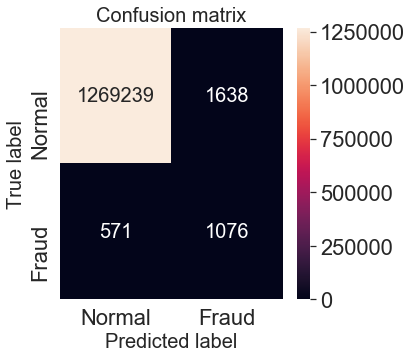

In [24]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
predictions = model.predict(X_test, batch_size=1000)

LABELS = ['Normal','Fraud'] 

max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [25]:
values = confusion_matrix.view()
print(values)
error_count = values.sum() - np.trace(values) # np.traceは行列の対角和
error_count

[[1269239    1638]
 [    571    1076]]


2209

### focal lossを使って  訓練

In [ ]:
from keras.models import Sequential
import tensorflow as tf

model = Sequential()

from keras.layers import Dense

input_dim = X_train.shape[1]
nb_classes = y_train.shape[1]

model.add(Dense(10, input_dim=input_dim, activation='relu', name='input'))
model.add(Dense(20, activation='relu', name='fc1'))
model.add(Dense(10, activation='relu', name='fc2'))
model.add(Dense(nb_classes, activation='softmax', name='output'))

In [30]:
model.compile(loss=my_loss.categorical_focal_loss(alpha=1.0, gamma=0)
              , metrics=["accuracy"]
              , optimizer='nadam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 10)                70        
_________________________________________________________________
fc1 (Dense)                  (None, 20)                220       
_________________________________________________________________
fc2 (Dense)                  (None, 10)                210       
_________________________________________________________________
output (Dense)               (None, 2)                 22        
Total params: 522
Trainable params: 522
Non-trainable params: 0
_________________________________________________________________


In [28]:
y_train.shape

(5090096, 2)

In [29]:
model.fit(X_train, y_train, epochs=3, batch_size=1000)

Epoch 1/3
5090096/5090096 [==============================] - 22s 4us/step - loss: 0.0035 - acc: 0.9993
Epoch 2/3
5090096/5090096 [==============================] - 22s 4us/step - loss: 0.0033 - acc: 0.9994
Epoch 3/3
5090096/5090096 [==============================] - 22s 4us/step - loss: 0.0030 - acc: 0.9994


In [31]:
score = model.evaluate(X_test, y_test, batch_size=1000)
score

1272524/1272524 [==============================] - 2s 1us/step


[0.010053557916290961, 0.9985375596603036]

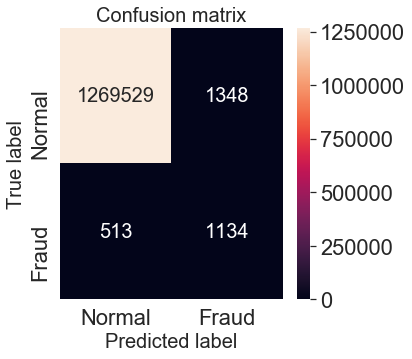

In [32]:

%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
predictions = model.predict(X_test, batch_size=1000)

LABELS = ['Normal','Fraud'] 

max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [33]:
values = confusion_matrix.view()
error_count = values.sum() - np.trace(values)
error_count

1861

In [35]:
from keras.models import Sequential
import tensorflow as tf

model = Sequential()

from keras.layers import Dense

input_dim = X_train.shape[1]
nb_classes = y_train.shape[1]

model.add(Dense(10, input_dim=input_dim, activation='relu', name='input'))
model.add(Dense(20, activation='relu', name='fc1'))
model.add(Dense(10, activation='relu', name='fc2'))
model.add(Dense(nb_classes, activation='softmax', name='output'))

model.compile(loss=my_loss.categorical_focal_loss(alpha=0.25, gamma=2)
              , metrics=["accuracy"]
              , optimizer='nadam')

model.fit(X_train, y_train, epochs=3, batch_size=1000)

score = model.evaluate(X_test, y_test, batch_size=1000)
print(score)

%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
predictions = model.predict(X_test, batch_size=1000)

LABELS = ['Normal','Fraud'] 

max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

values = confusion_matrix.view()
error_count = values.sum() - np.trace(values)
error_count

Epoch 1/3
5090096/5090096 [==============================] - 23s 4us/step - loss: 4.9989e-04 - acc: 0.9989
Epoch 2/3
5090096/5090096 [==============================] - 22s 4us/step - loss: 2.6500e-04 - acc: 0.9993
Epoch 3/3
1272524/1272524 [==============================] - 2s 1us/step
[0.0002560089675654173, 0.9993304712672072]


852

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
np.random.seed(42)

def get_imbalance_train_data():
    """ 超不均衡多クラス分類データ取得 """
    # create data frame containing your data, each column can be accessed # by df['column   name']
    dataset = pd.read_csv(r'D:\work\kaggle_data\fraud_detection_dataset_on_Kaggle\paysim1/PS_20174392719_1491204439457_log.csv')
    del dataset['nameDest']
    del dataset['nameOrig']
    del dataset['type']
    print(dataset['isFraud'].value_counts())
    
    def feature_normalize(dataset):
        mu = np.mean(dataset, axis=0)
        sigma = np.std(dataset, axis=0)
        return (dataset - mu) / sigma
    
    #Splitting the Training/Test Data
    from sklearn.model_selection  import train_test_split
    X, y = dataset.iloc[:,:-2], dataset.iloc[:, -2]
    y = keras.utils.to_categorical(y, num_classes=2)
    X = feature_normalize(X.as_matrix())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    return X_train, X_test, y_train, y_test

def train_imbalance_model(my_loss = my_loss.categorical_focal_loss(alpha=0.25, gamma=2)
                 , class_weight = None):
    """ 超不均衡データで lossとclass_weight 変えたときの多クラス分類モデル比較 """
    print("########################################################")
    
    X_train, X_test, y_train, y_test = get_imbalance_train_data()
    
    from keras.models import Sequential
    import tensorflow as tf

    model = Sequential()

    from keras.layers import Dense

    input_dim = X_train.shape[1]
    nb_classes = y_train.shape[1]

    model.add(Dense(10, input_dim=input_dim, activation='relu', name='input'))
    model.add(Dense(20, activation='relu', name='fc1'))
    model.add(Dense(10, activation='relu', name='fc2'))
    model.add(Dense(nb_classes, activation='softmax', name='output'))

    model.compile(loss=my_loss
                  , metrics=["accuracy"]
                  , optimizer='nadam')
    #model.summary()

    if class_weight is not None:
        model.fit(X_train, y_train, epochs=3, batch_size=1000, class_weight=class_weight)
    else:
        model.fit(X_train, y_train, epochs=3, batch_size=1000)

    score = model.evaluate(X_test, y_test, batch_size=1000)
    print(score)

    %matplotlib inline
    from sklearn import metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(font_scale=2)
    predictions = model.predict(X_test, batch_size=1000)

    LABELS = ['Normal','Fraud'] 

    max_test = np.argmax(y_test, axis=1)
    max_predictions = np.argmax(predictions, axis=1)
    confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

    values = confusion_matrix.view()
    error_count = values.sum() - np.trace(values)
    print(f'error_count:{error_count}')
    
    return confusion_matrix

confusion_matrix = train_imbalance_model(my_loss = 'categorical_crossentropy', class_weight = {0 : 1., 1: 20.})
confusion_matrix = train_imbalance_model(my_loss = my_loss.categorical_focal_loss(alpha=1.0, gamma=0))
confusion_matrix = train_imbalance_model(my_loss = my_loss.categorical_focal_loss(alpha=0.25, gamma=2))


############################
0    6354407
1       8213
Name: isFraud, dtype: int64


C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch 1/3
5090096/5090096 [==============================] - 22s 4us/step - loss: 0.0570 - acc: 0.9980
Epoch 2/3
2653000/5090096 [==============>...............] - ETA: 10s - loss: 0.0413 - acc: 0.9974

In [ ]:
def plot_seaborn_conf_matrix(confusion_matrix):
    %matplotlib inline
    from sklearn import metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(font_scale=2)
    #predictions = model.predict(X_test, batch_size=1000)
    LABELS = ['Normal','Fraud'] 
    #max_test = np.argmax(y_test, axis=1)
    #max_predictions = np.argmax(predictions, axis=1)
    #confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
    plt.title("Confusion matrix", fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.show()
    
plot_seaborn_conf_matrix(confusion_matrix)